# node2vec
---
[node2vec](http://snap.stanford.edu/node2vec/) for link prediction:
1. Perform train-test split
1. Train skip-gram model on random walks within training graph
2. Get node embeddings from skip-gram model
3. Create bootstrapped edge embeddings by taking the Hadamard product of node embeddings
4. Train a logistic regression classifier on these edge embeddings (possible edge --> edge score between 0-1)
5. Evaluate these edge embeddings on the validation and test edge sets

node2vec source code: https://github.com/aditya-grover/node2vec

Dataset: Dynamic Enron employees
Number of nodes: 151
Number of edges: 1612
Number of time frames: 4

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import pickle

In [2]:
#EGO_USER = 0 # which ego network to look at

# Load pickled (adj, feat) tuple
#network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
#with open(network_dir, 'rb') as f:
#    adj, features = pickle.load(f)
    
#g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)

Step 1: Load in the networks, make the training and test edge lists

In [183]:
MasterGraph = nx.read_edgelist("contacts_dublin/dublin.csv", nodetype=int, delimiter=",")
for edge in MasterGraph.edges():
    MasterGraph[edge[0]][edge[1]]['weight'] = 1

print MasterGraph.number_of_nodes()
print MasterGraph.number_of_edges()

G1 = nx.read_edgelist("contacts_dublin/dublin_w1.csv", nodetype = int, delimiter = ",")
for edge in G1.edges():
    G1[edge[0]][edge[1]]['weight'] = 1
G2 = nx.read_edgelist("contacts_dublin/dublin_w2.csv", nodetype = int, delimiter = ",")
for edge in G2.edges():
    G2[edge[0]][edge[1]]['weight'] = 1
G3 = nx.read_edgelist("contacts_dublin/dublin_w3.csv", nodetype = int, delimiter = ",")
for edge in G3.edges():
    G3[edge[0]][edge[1]]['weight'] = 1
G4 = nx.read_edgelist("contacts_dublin/dublin_w4.csv", nodetype = int, delimiter = ",")
for edge in G4.edges():
    G4[edge[0]][edge[1]]['weight'] = 1
G5 = nx.read_edgelist("contacts_dublin/dublin_w5.csv", nodetype = int, delimiter = ",")
for edge in G5.edges():
    G5[edge[0]][edge[1]]['weight'] = 1
G6 = nx.read_edgelist("contacts_dublin/dublin_w6.csv", nodetype = int, delimiter = ",")
for edge in G6.edges():
    G6[edge[0]][edge[1]]['weight'] = 1
G7 = nx.read_edgelist("contacts_dublin/dublin_w7.csv", nodetype = int, delimiter = ",")
for edge in G7.edges():
    G7[edge[0]][edge[1]]['weight'] = 1
G8 = nx.read_edgelist("contacts_dublin/dublin_w8.csv", nodetype = int, delimiter = ",")
for edge in G8.edges():
    G8[edge[0]][edge[1]]['weight'] = 1

G17 = nx.read_edgelist("contacts_dublin/dublin_w17.csv", nodetype = int, delimiter = ",")
for edge in G17.edges():
    G17[edge[0]][edge[1]]['weight'] = 1

    
    
## All the nodes are in MasterNodes    
MasterNodes = MasterGraph.nodes()

6454
24097


In [184]:
### Training - Test split  
'''''
first add all the nodes that are in MasterGraph but not in 
G4
'''''
for i in MasterNodes:
    if i not in G8.nodes():
        G8.add_node(i)
        
adj_sparse = nx.to_scipy_sparse_matrix(G8)

In [185]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks

adj_sparse = nx.to_scipy_sparse_matrix(G8)

adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.0, prevent_disconnect = True)


In [186]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Training edges (negative):", len(train_edges_false)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 6454
Total edges: 3242
Training edges (positive): 2270
Training edges (negative): 2270
Validation edges (positive): 0
Validation edges (negative): 0
Test edges (positive): 972
Test edges (negative): 972


The positive training edges are in the edgelist "train_edges".

The negative training edges are in the edgelist "train_edges_false".

The positive test edges are in the edgelist "test_edges".

The negative test edges are in the edgelist "test_edges_false".

Step 2: add all the nodes in G1, G2, G3 that are not present

In [187]:
'''
add all the nodes that are in the MasterGraph but not in 
G1, G2 and G3
'''
for i in MasterNodes:
    if i not in G1.nodes():
        G1.add_node(i)
    if i not in G2.nodes():
        G2.add_node(i)
    if i not in G3.nodes():
        G3.add_node(i)
    if i not in G4.nodes():
        G4.add_node(i)
    if i not in G5.nodes():
        G5.add_node(i)
    if i not in G6.nodes():
        G6.add_node(i)
    if i not in G7.nodes():
        G7.add_node(i)
    if i not in G17.nodes():
        G17.add_node(i)

In [188]:
print "Edges before removal: "
print "G1:  ", G1.number_of_edges()
print "G2:  ", G2.number_of_edges()
print "G3:  ", G3.number_of_edges()
print "G4:  ", G4.number_of_edges()
print "G5:  ", G5.number_of_edges()
print "G6:  ", G6.number_of_edges()
print "G7:  ", G7.number_of_edges()
print "G17:  ", G17.number_of_edges()


'''
for every snapshot, delete all the edges that occur in the 
test set, this is important because the training of node2vec
can only be done on the training network and not on edges that
are used for testing
'''
for i in range(0,len(test_edges)):
        if G1.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G1.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G2.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G2.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G3.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G3.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G4.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G4.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G5.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G5.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G6.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G6.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G7.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G7.remove_edge(test_edges[i, 0], test_edges[i, 1])
        if G17.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G17.remove_edge(test_edges[i, 0], test_edges[i, 1])
            
print "Edges after removal: "
print "G1:  ", G1.number_of_edges()
print "G2:  ", G2.number_of_edges()
print "G3:  ", G3.number_of_edges()
print "G4:  ", G4.number_of_edges()
print "G5:  ", G5.number_of_edges()
print "G6:  ", G6.number_of_edges()
print "G7:  ", G7.number_of_edges()
print "G17:  ", G17.number_of_edges()

Edges before removal: 
G1:   4210
G2:   4785
G3:   2951
G4:   2296
G5:   2173
G6:   2446
G7:   1994
G17:   20855
Edges after removal: 
G1:   4210
G2:   4785
G3:   2951
G4:   2296
G5:   2173
G6:   2446
G7:   1994
G17:   20855


## 3. Train node2vec (Learn Node Embeddings)

In [189]:
import node2vec
from gensim.models import Word2Vec

In [190]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [191]:
# Preprocessing, generate walks
G1_n2v = node2vec.Graph(G1, DIRECTED, P, Q) # create node2vec graph instance
G2_n2v = node2vec.Graph(G2, DIRECTED, P, Q)
G3_n2v = node2vec.Graph(G3, DIRECTED, P, Q)
G4_n2v = node2vec.Graph(G4, DIRECTED, P, Q) 
G5_n2v = node2vec.Graph(G5, DIRECTED, P, Q)
G6_n2v = node2vec.Graph(G6, DIRECTED, P, Q)
G7_n2v = node2vec.Graph(G7, DIRECTED, P, Q)
G17_n2v = node2vec.Graph(G17, DIRECTED, P, Q)

G1_n2v.preprocess_transition_probs()
G2_n2v.preprocess_transition_probs()
G3_n2v.preprocess_transition_probs()
G4_n2v.preprocess_transition_probs()
G5_n2v.preprocess_transition_probs()
G6_n2v.preprocess_transition_probs()
G7_n2v.preprocess_transition_probs()
G17_n2v.preprocess_transition_probs()

walksG1 = G1_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG2 = G2_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG3 = G3_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG4 = G4_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG5 = G5_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG6 = G6_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG7 = G7_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walksG17 = G17_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)

walksG1 = [map(str, walk) for walk in walksG1]
walksG2 = [map(str, walk) for walk in walksG2]
walksG3 = [map(str, walk) for walk in walksG3]
walksG4 = [map(str, walk) for walk in walksG4]
walksG5 = [map(str, walk) for walk in walksG5]
walksG6 = [map(str, walk) for walk in walksG6]
walksG7 = [map(str, walk) for walk in walksG7]
walksG17 = [map(str, walk) for walk in walksG17]

# Train skip-gram model
modelG1 = Word2Vec(walksG1, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG2 = Word2Vec(walksG2, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG3 = Word2Vec(walksG3, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG4 = Word2Vec(walksG4, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG5 = Word2Vec(walksG5, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG6 = Word2Vec(walksG6, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG7 = Word2Vec(walksG7, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)
modelG17 = Word2Vec(walksG17, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)


# Store embeddings mapping
emb_mappingsG1 = modelG1.wv
emb_mappingsG2 = modelG2.wv
emb_mappingsG3 = modelG3.wv
emb_mappingsG4 = modelG4.wv
emb_mappingsG5 = modelG5.wv
emb_mappingsG6 = modelG6.wv
emb_mappingsG7 = modelG7.wv
emb_mappingsG17 = modelG17.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [192]:
adj_sparse.shape[0]

6454

## 4. Create Edge Embeddings

In [193]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_listG1 = []
emb_listG2 = []
emb_listG3 = []
emb_listG4 = []
emb_listG5 = []
emb_listG6 = []
emb_listG7 = []
emb_listG17 = []

for node_index in MasterGraph.nodes():
    node_str = str(node_index)
    
    node_embG1 = emb_mappingsG1[node_str]
    node_embG2 = emb_mappingsG2[node_str]
    node_embG3 = emb_mappingsG3[node_str]
    node_embG4 = emb_mappingsG4[node_str]
    node_embG5 = emb_mappingsG5[node_str]
    node_embG6 = emb_mappingsG6[node_str]
    node_embG7 = emb_mappingsG7[node_str]
    node_embG17 = emb_mappingsG17[node_str]
    
    emb_listG1.append(node_embG1)
    emb_listG2.append(node_embG2)
    emb_listG3.append(node_embG3)
    emb_listG4.append(node_embG4)
    emb_listG5.append(node_embG5)
    emb_listG6.append(node_embG6)
    emb_listG7.append(node_embG7)
    emb_listG17.append(node_embG17)
    
emb_matrixG1 = np.vstack(emb_listG1)
emb_matrixG2 = np.vstack(emb_listG2)
emb_matrixG3 = np.vstack(emb_listG3)
emb_matrixG4 = np.vstack(emb_listG4)
emb_matrixG5 = np.vstack(emb_listG5)
emb_matrixG6 = np.vstack(emb_listG6)
emb_matrixG7 = np.vstack(emb_listG7)
emb_matrixG17 = np.vstack(emb_listG17)

In [194]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings_dynamic(edge_list):
    embs = []
    for edge in edge_list:
        
        node1 = edge[0]
        node2 = edge[1]
        
        embG1_1 = emb_matrixG1[node1]
        embG1_2 = emb_matrixG1[node2]
        
        embG2_1 = emb_matrixG2[node1]
        embG2_2 = emb_matrixG2[node2]
        
        embG3_1 = emb_matrixG3[node1]
        embG3_2 = emb_matrixG3[node2]
        
        embG4_1 = emb_matrixG4[node1]
        embG4_2 = emb_matrixG4[node2]
        
        embG5_1 = emb_matrixG5[node1]
        embG5_2 = emb_matrixG5[node2]
        
        embG6_1 = emb_matrixG6[node1]
        embG6_2 = emb_matrixG6[node2]
        
        embG7_1 = emb_matrixG7[node1]
        embG7_2 = emb_matrixG7[node2]
        
        edge_embG1 = np.multiply(embG1_1, embG1_2)
        edge_embG2 = np.multiply(embG2_1, embG2_2)
        edge_embG3 = np.multiply(embG3_1, embG3_2)
        edge_embG4 = np.multiply(embG4_1, embG4_2)
        edge_embG5 = np.multiply(embG5_1, embG5_2)
        edge_embG6 = np.multiply(embG6_1, embG6_2)
        edge_embG7 = np.multiply(embG7_1, embG7_2)
        
        edge_emb = np.hstack((edge_embG1,edge_embG2, edge_embG3, edge_embG4, edge_embG5, edge_embG6, edge_embG7))
        embs.append(edge_emb)
        
    embs = np.array(embs)
    
    return embs

In [195]:
def get_edge_embeddings_static(edge_list):
    embs_s = []
    for edge in edge_list:
        
        node1 = edge[0]
        node2 = edge[1]
        
        embG17_1 = emb_matrixG17[node1]
        embG17_2 = emb_matrixG17[node2]
        
        edge_embG17 = np.multiply(embG17_1, embG17_2)
        embs_s.append(edge_embG17)
        
    embs_s = np.array(embs_s)
    
    return embs_s

In [196]:
## DYNAMIC
# Train-set edge embeddings
pos_train_edge_embs_d = get_edge_embeddings_dynamic(train_edges)
neg_train_edge_embs_d = get_edge_embeddings_dynamic(train_edges_false)
train_edge_embs_d = np.concatenate([pos_train_edge_embs_d, neg_train_edge_embs_d])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs_d = get_edge_embeddings_dynamic(val_edges)
neg_val_edge_embs_d = get_edge_embeddings_dynamic(val_edges_false)
val_edge_embs_d = np.concatenate([pos_val_edge_embs_d, neg_val_edge_embs_d])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs_d = get_edge_embeddings_dynamic(test_edges)
neg_test_edge_embs_d = get_edge_embeddings_dynamic(test_edges_false)
test_edge_embs_d = np.concatenate([pos_test_edge_embs_d, neg_test_edge_embs_d])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [197]:
## STATIC
# Train-set edge embeddings
pos_train_edge_embs_s = get_edge_embeddings_static(train_edges)
neg_train_edge_embs_s = get_edge_embeddings_static(train_edges_false)
train_edge_embs_s = np.concatenate([pos_train_edge_embs_s, neg_train_edge_embs_s])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs_s = get_edge_embeddings_static(val_edges)
neg_val_edge_embs_s = get_edge_embeddings_static(val_edges_false)
val_edge_embs_s = np.concatenate([pos_val_edge_embs_s, neg_val_edge_embs_s])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs_s = get_edge_embeddings_static(test_edges)
neg_test_edge_embs_s = get_edge_embeddings_static(test_edges_false)
test_edge_embs_s = np.concatenate([pos_test_edge_embs_s, neg_test_edge_embs_s])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

## 5. Evaluate Edge Embeddings

First, the basic topological classifiers are calculated for the test and training set.

In [198]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


edge_classifier_lr_stat = LogisticRegression(random_state=0)
edge_classifier_lr_stat.fit(train_edge_embs_s, train_edge_labels)

edge_classifier_lr_dyn = LogisticRegression(random_state=0)
edge_classifier_lr_dyn.fit(train_edge_embs_d, train_edge_labels)

edge_classifier_RF_stat = RandomForestClassifier(n_estimators = 50)
edge_classifier_RF_stat.fit(train_edge_embs_s, train_edge_labels)

edge_classifier_RF_dyn = RandomForestClassifier(n_estimators = 50)
edge_classifier_RF_dyn.fit(train_edge_embs_d, train_edge_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
##  Gradient Boosted Regression Trees
from sklearn.ensemble import GradientBoostingClassifier
edge_classifier_gb_stat = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_depth=8, random_state=0).fit(train_edge_embs_s, train_edge_labels)
edge_classifier_gb_dyn = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_depth=8, random_state=0).fit(train_edge_embs_d, train_edge_labels)

In [200]:
# Predicted edge scores: probability of being of class "1" (real edge)
# val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
# val_roc = roc_auc_score(val_edge_labels, val_preds)
# val_ap = average_precision_score(val_edge_labels, val_preds)

In [201]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds_lr_s = edge_classifier_lr_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_lr_s = roc_auc_score(test_edge_labels, test_preds_lr_s)
test_ap_lr_s = average_precision_score(test_edge_labels, test_preds_lr_s)

test_preds_lr_d = edge_classifier_lr_dyn.predict_proba(test_edge_embs_d)[:, 1]
test_roc_lr_d = roc_auc_score(test_edge_labels, test_preds_lr_d)
test_ap_lr_d = average_precision_score(test_edge_labels, test_preds_lr_d)

test_preds_rf_s = edge_classifier_RF_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_rf_s = roc_auc_score(test_edge_labels, test_preds_rf_s)
test_ap_rf_s = average_precision_score(test_edge_labels, test_preds_rf_s)

test_preds_rf_d = edge_classifier_RF_dyn.predict_proba(test_edge_embs_d)[:, 1]
test_roc_rf_d = roc_auc_score(test_edge_labels, test_preds_rf_d)
test_ap_rf_d = average_precision_score(test_edge_labels, test_preds_rf_d)

test_preds_gb_s = edge_classifier_gb_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_gb_s = roc_auc_score(test_edge_labels, test_preds_gb_s)
test_ap_gb_s = average_precision_score(test_edge_labels, test_preds_gb_s)

test_preds_gb_d = edge_classifier_gb_dyn.predict_proba(test_edge_embs_d)[:, 1]
test_roc_gb_d = roc_auc_score(test_edge_labels, test_preds_gb_d)
test_ap_gb_d = average_precision_score(test_edge_labels, test_preds_gb_d)

In [202]:
# print 'node2vec Validation ROC score: ', str(val_roc)
# print 'node2vec Validation AP score: ', str(val_ap)
print 'node2vec Test ROC score logistic regression static: ', str(test_roc_lr_s)
print 'node2vec Test ROC score logistic regression dynamic: ', str(test_roc_lr_d)
print 'node2vec Test ROC score random forest static: ', str(test_roc_rf_s)
print 'node2vec Test ROC score random forest dynamic: ', str(test_roc_rf_d)
print 'node2vec Test ROC score gradient boosting static: ', str(test_roc_gb_s)
print 'node2vec Test ROC score gradient boosting dynamic: ', str(test_roc_gb_d)
print 'node2vec Test AP score logistic regression static: ', str(test_ap_lr_s)
print 'node2vec Test AP score logistic regression dynamic: ', str(test_ap_lr_d)
print 'node2vec Test AP score random forest static: ', str(test_ap_rf_s)
print 'node2vec Test AP score random forest dynamic: ', str(test_ap_rf_d)
print 'node2vec Test AP score gradient boosting static: ', str(test_ap_gb_s)
print 'node2vec Test AP score gradient boosting dynamic: ', str(test_ap_gb_d)

node2vec Test ROC score logistic regression static:  0.8620626513573474
node2vec Test ROC score logistic regression dynamic:  0.5694846652779895
node2vec Test ROC score random forest static:  0.9864487544242917
node2vec Test ROC score random forest dynamic:  0.9864815661569205
node2vec Test ROC score gradient boosting static:  0.9801737751697741
node2vec Test ROC score gradient boosting dynamic:  0.9855252629172383
node2vec Test AP score logistic regression static:  0.712017692037616
node2vec Test AP score logistic regression dynamic:  0.48276282821553784
node2vec Test AP score random forest static:  0.973081369300067
node2vec Test AP score random forest dynamic:  0.9735388969695389
node2vec Test AP score gradient boosting static:  0.9713263687254011
node2vec Test AP score gradient boosting dynamic:  0.9744959346706513


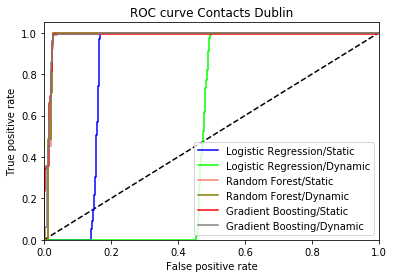

In [23]:
## ROC curve
fpr_lr_s, tpr_lr_s, _ = roc_curve(test_edge_labels, test_preds_lr_s)
fpr_lr_d, tpr_lr_d, _ = roc_curve(test_edge_labels, test_preds_lr_d)
fpr_rf_s, tpr_rf_s, _ = roc_curve(test_edge_labels, test_preds_rf_s)
fpr_rf_d, tpr_rf_d, _ = roc_curve(test_edge_labels, test_preds_rf_d)
fpr_gb_s, tpr_gb_s, _ = roc_curve(test_edge_labels, test_preds_gb_s)
fpr_gb_d, tpr_gb_d, _ = roc_curve(test_edge_labels, test_preds_gb_d)


fig_roc = plt.figure()

plt.plot([0,1], [0, 1], 'k--')
plt.step(fpr_lr_s, tpr_lr_s, color = "b", alpha = 1, where = 'post', label = "Logistic Regression/Static")
plt.step(fpr_lr_d, tpr_lr_d, color = "lime", alpha = 1, where = 'post', label = "Logistic Regression/Dynamic")
plt.step(fpr_rf_s, tpr_rf_s, color = "salmon", alpha = 1, where = 'post', label = "Random Forest/Static")
plt.step(fpr_rf_d, tpr_rf_d, color = "olive", alpha = 1, where = 'post', label = "Random Forest/Dynamic")
plt.step(fpr_gb_s, tpr_gb_s, color = "red", alpha = 1, where = 'post', label = "Gradient Boosting/Static")
plt.step(fpr_gb_d, tpr_gb_d, color = "grey", alpha = 1, where = 'post', label = "Gradient Boosting/Dynamic")



plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve Contacts Dublin')

plt.legend()

fig_roc.savefig("ROC_contactsdublin.png")



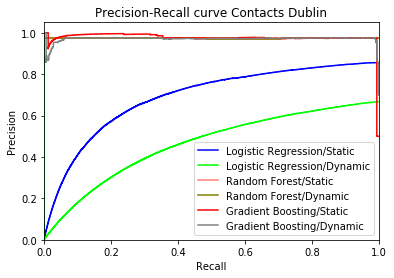

In [24]:
## Precision - Recall curve

precision_lr_s, recall_lr_s, _ = precision_recall_curve(test_edge_labels, test_preds_lr_s)
precision_rf_s, recall_rf_s, _ = precision_recall_curve(test_edge_labels, test_preds_rf_s)
precision_lr_d, recall_lr_d, _ = precision_recall_curve(test_edge_labels, test_preds_lr_d)
precision_rf_d, recall_rf_d, _ = precision_recall_curve(test_edge_labels, test_preds_rf_d)
precision_gb_s, recall_gb_s, _ = precision_recall_curve(test_edge_labels, test_preds_gb_s)
precision_gb_d, recall_gb_d, _ = precision_recall_curve(test_edge_labels, test_preds_gb_d)

fig_aupr = plt.figure()

plt.step(recall_lr_s, precision_lr_s, color="b", alpha=1, where='post', label = "Logistic Regression/Static")
plt.step(recall_lr_d, precision_lr_d, color="lime", alpha=1, where='post', label = "Logistic Regression/Dynamic")

plt.step(recall_rf_s, precision_rf_s, color="salmon", alpha=1, where='post', label = "Random Forest/Static")
plt.step(recall_rf_d, precision_rf_d, color="olive", alpha=1, where='post', label = "Random Forest/Dynamic")

plt.step(recall_gb_s,precision_gb_s,  color="red", alpha=1, where='post', label = "Gradient Boosting/Static")
plt.step( recall_gb_d,precision_gb_d, color="grey", alpha=1, where='post', label = "Gradient Boosting/Dynamic")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve Contacts Dublin')

plt.legend()

fig_aupr.savefig("AUPR_contactsdublin.png")

#plt.step(recall_rf_s, precision_rf_s, color="salmon", alpha=1, where='post', label = "Random Forest/Static")
#plt.step(recall_rf_d, precision_rf_d, color="olive", alpha=1, where='post', label = "Random Forest/Dynamic")
#plt.fill_between(recall_lr_s, precision_lr_s, step="post", alpha=0.2, color="b")

#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.title('Precision-Recall curve Enron employees')

#plt.legend()


#fig.savefig("AUPR_Enron.png")

# Baseline classifiers (Adamic Adar, Jaccard Index & Preferred Attachement)
---

In [25]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

In [26]:
adj = nx.adjacency_matrix(MasterGraph)
    
adj_sparse = nx.to_scipy_sparse_matrix(MasterGraph)    
    
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.00)    
    
g_train = nx.from_scipy_sparse_matrix(adj_train)



## 3. Adamic-Adar

In [27]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [28]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print 'Adamic-Adar Test ROC score: ', str(aa_roc)
print 'Adamic-Adar Test AP score: ', str(aa_ap)

Adamic-Adar Test ROC score:  0.9142118686625188
Adamic-Adar Test AP score:  0.9142110978885104


## 4. Jaccard Coefficient

In [29]:
# Compute Jaccard Coefficients from g_train
jc_matrix = np.zeros(adj.shape)
for u, v, p in nx.jaccard_coefficient(g_train): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

In [30]:
# Calculate ROC AUC and Average Precision
jc_roc, jc_ap = get_roc_score(test_edges, test_edges_false, jc_matrix)

print 'Jaccard Coefficient Test ROC score: ', str(jc_roc)
print 'Jaccard Coefficient Test AP score: ', str(jc_ap)

Jaccard Coefficient Test ROC score:  0.914143353415384
Jaccard Coefficient Test AP score:  0.9140421081464922
